In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install openTSNE


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.0 MB/s eta 0:00:00


In [3]:
import numpy as np
from sklearn.decomposition import PCA
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#Faster and better
from openTSNE import TSNE

import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

from tqdm import tqdm

#If you use tensorflow version
# import tensorflow as tf
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras import layers, models, optimizers, losses, metrics
# from tensorflow.keras.applications import DenseNet121
# from sklearn.metrics import accuracy_score


In [4]:
random.seed(42)
np.random.seed(42)

Load Data

In [6]:
embeddingData = np.load("/content/drive/MyDrive/VinCR/features_train.npy", allow_pickle=True)
allData = pd.read_csv("/content/drive/MyDrive/VinCR/train.csv")

allData['image_id'] = allData['image_id'].str.lower()
allData['class_name'] = allData['class_name'].str.lower()

print(allData.head())




                           image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          no finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          no finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          no finding        14    R10   

    x_min   y_min   x_max   y_max  
0     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN  
2   691.0  1375.0  1653.0  1831.0  
3  1264.0   743.0  1611.0  1019.0  
4     NaN     NaN     NaN     NaN  


In [7]:
unique_names = allData['class_name'].unique()
print(unique_names)

['no finding' 'cardiomegaly' 'aortic enlargement' 'pleural thickening'
 'ild' 'nodule/mass' 'pulmonary fibrosis' 'lung opacity' 'atelectasis'
 'other lesion' 'infiltration' 'pleural effusion' 'calcification'
 'consolidation' 'pneumothorax']


In [8]:
# Define the mapping for grouping
group_mapping = {
    'no finding': 'no finding',
    'cardiomegaly': 'cardiovascular-related',
    'aortic enlargement': 'cardiovascular-related',
    'pleural thickening': 'pleural abnormalities',
    'pleural effusion': 'pleural abnormalities',
    'pneumothorax': 'pleural abnormalities',
    'ild': 'interstitial and parenchymal lung diseases',
    'pulmonary fibrosis': 'interstitial and parenchymal lung diseases',
    'atelectasis': 'interstitial and parenchymal lung diseases',
    'lung opacity': 'interstitial and parenchymal lung diseases',
    'nodule/mass': 'nodules, masses, or lesions',
    'other lesion': 'nodules, masses, or lesions',
    'calcification': 'nodules, masses, or lesions',
    'infiltration': 'inflammatory/infectious conditions',
    'consolidation': 'inflammatory/infectious conditions'
}

grouped_id_mapping = {
    'no finding': 0,
    'cardiovascular-related': 1,
    'pleural abnormalities': 2,
    'interstitial and parenchymal lung diseases': 3,
    'nodules, masses, or lesions': 4,
    'inflammatory/infectious conditions': 5
}

# Add the grouped_class column
allData['grouped_class'] = allData['class_name'].map(group_mapping)

# Add the grouped_id column
allData['grouped_id'] = allData['grouped_class'].map(grouped_id_mapping)

reclassifiedData = allData
reclassifiedData.head()


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,grouped_class,grouped_id
0,50a418190bc3fb1ef1633bf9678929b3,no finding,14,R11,NaN,NaN,NaN,NaN,no finding,0
1,21a10246a5ec7af151081d0cd6d65dc9,no finding,14,R7,NaN,NaN,NaN,NaN,no finding,0
2,9a5094b2563a1ef3ff50dc5c7ff71345,cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,cardiovascular-related,1
3,051132a778e61a86eb147c7c6f564dfe,aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,cardiovascular-related,1
4,063319de25ce7edb9b1c6b8881290140,no finding,14,R10,NaN,NaN,NaN,NaN,no finding,0


t-SNE of Embedded Features

In [9]:


labelDict = dict(zip(reclassifiedData['image_id'], allData['grouped_class']))
print(labelDict)

embeddingData[:, 0] = np.array([name.replace('.jpg', '').lower() for name in embeddingData[:, 0]])
embeddedSamplesLabels = np.array([labelDict.get(name, 'unknown') for name in embeddingData[:, 0]])
print(embeddedSamplesLabels[0:5])

embeddingData = np.hstack((embeddingData, embeddedSamplesLabels.reshape(-1, 1)))



{'50a418190bc3fb1ef1633bf9678929b3': 'no finding', '21a10246a5ec7af151081d0cd6d65dc9': 'no finding', '9a5094b2563a1ef3ff50dc5c7ff71345': 'cardiovascular-related', '051132a778e61a86eb147c7c6f564dfe': 'cardiovascular-related', '063319de25ce7edb9b1c6b8881290140': 'no finding', '1c32170b4af4ce1a3030eb8167753b06': 'interstitial and parenchymal lung diseases', '0c7a38f293d5f5e4846aa4ca6db4daf1': 'nodules, masses, or lesions', '47ed17dcb2cbeec15182ed335a8b5a9e': 'interstitial and parenchymal lung diseases', 'd3637a1935a905b3c326af31389cb846': 'interstitial and parenchymal lung diseases', 'afb6230703512afc370f236e8fe98806': 'inflammatory/infectious conditions', '7c1add6833d5f0102b0d3619a1682a64': 'inflammatory/infectious conditions', '18a61a07e6f5f13ebfee57fa36cd8b6f': 'pleural abnormalities', '5550a493b1c4554da469a072fdfab974': 'no finding', '869f39afbdd8783b531530942eda8bad': 'no finding', '321c111713c3ee5385db0effb54ff568': 'nodules, masses, or lesions', 'f55460fccf2d3c591f57f9c0de2c37c2': 

In [ ]:
#Old classifications

# labelDict = dict(zip(allData['image_id'], allData['class_name']))
# print(labelDict)

# embeddingData[:, 0] = np.array([name.replace('.jpg', '').lower() for name in embeddingData[:, 0]])
# embeddedSamplesLabels = np.array([labelDict.get(name, 'unknown') for name in embeddingData[:, 0]])
# print(embeddedSamplesLabels[0:5])

# embeddingData = np.hstack((embeddingData, embeddedSamplesLabels.reshape(-1, 1)))

In [ ]:
#Review embedding data
print(type(embeddingData))
print(embeddingData.shape)

#name of image sample
print(f"First image sample name = {embeddingData[0][0]}")

#length 512 - num of embedding dimensions
print(f"Number of embedded dimensions = {len(embeddingData[0][1][0])}")


<class 'numpy.ndarray'>
(15000, 3)
First image sample name = 34e635f644f6d4853776e2d74357b239
Number of embedded dimensions = 512


In [ ]:
#Obtain the specific feature embeddings for each of the 15000 samples
embeddings = np.array([item[1] for item in embeddingData])
embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[2])

print(embeddings.shape)

scaler = StandardScaler()
normalizedEmbeddings = scaler.fit_transform(embeddings)

(15000, 512)


In [ ]:
#https://opentsne.readthedocs.io/en/stable/index.html

tsne = TSNE(
    perplexity=30, #30
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

#Run t-SNE embedding
embeddings2DRaw = tsne.fit(embeddings) #embeddings
embeddings2DNormalized = tsne.fit(normalizedEmbeddings) #embeddings

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 28.11 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.86 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.72 seconds
===> Running optimization with exaggeration=12.00, lr=1250.00 for 250 iterations...
Iteration   50, KL divergence 4.7623, 50 iterations in 4.6467 sec
Iteration  100, KL divergence 4.7628, 50 iterations in 3.3603 sec
Iteration  150, KL divergence 4.7515, 50 iterations in 2.2058 sec
Iteration  200, KL divergence 4.7458, 50 iterations in 2.1990 sec
Iteration  250, KL divergence 4.7421, 50 iterations in 2.2550 sec
   --> Time elapsed: 14.67 seconds
===> Running optimization with exaggeration

<ipython-input-12-96b050a06893>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("plasma", len(uniqueLabels))


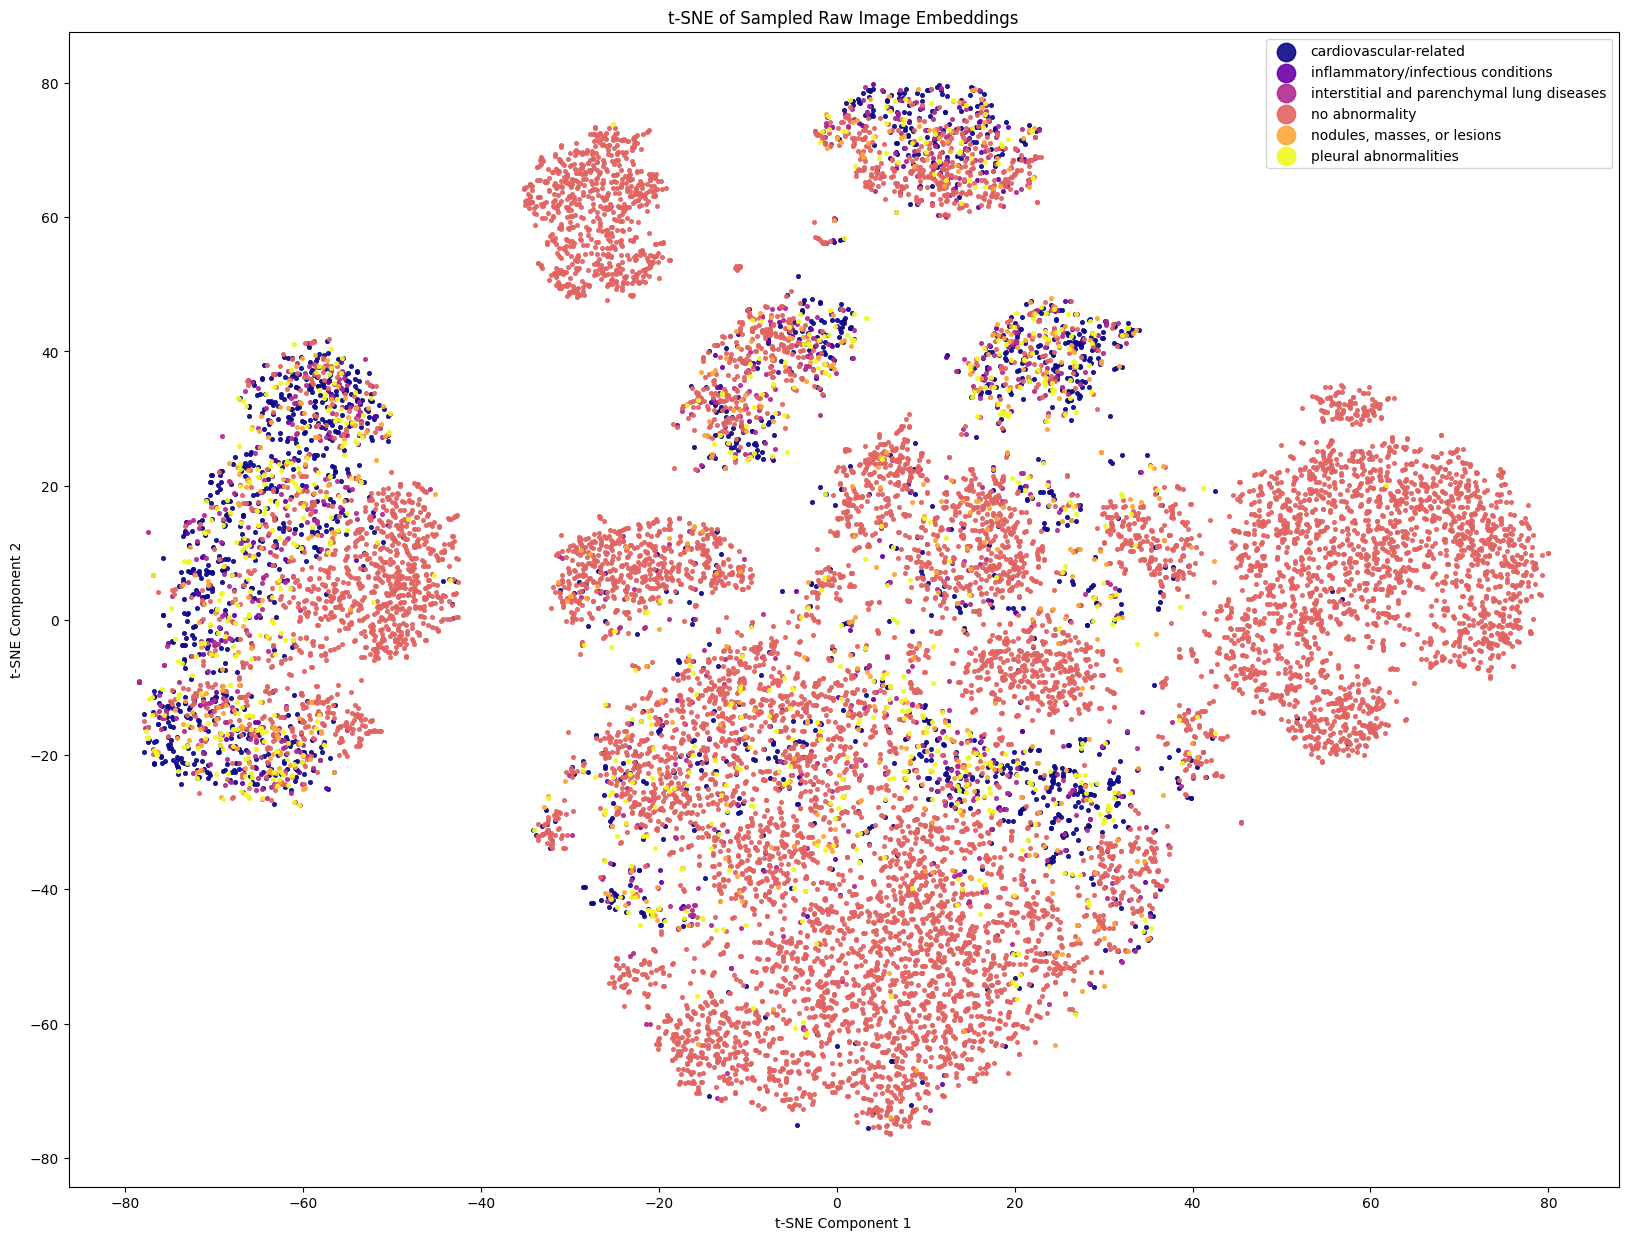

In [ ]:
#Plotting with color for each label
plt.figure(figsize=(20, 15))  # Increase the figure size

#Use unique labels for consistent coloring
uniqueLabels = np.unique(embeddedSamplesLabels)
colors = plt.cm.get_cmap("plasma", len(uniqueLabels))

#Map each label to a color
labelToColor = {label: colors(i) for i, label in enumerate(uniqueLabels)}

#Plot each point, colored by its label
for label in uniqueLabels:
    indices = embeddedSamplesLabels == label
    plt.scatter(
        embeddings2DRaw[indices, 0],
        embeddings2DRaw[indices, 1],
        s=7,
        alpha=.9,
        color=labelToColor[label],
        label=label
    )

plt.title('t-SNE of Sampled Raw Image Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc="best", markerscale=5, fontsize='medium')
plt.show()


<ipython-input-13-01e10e95d263>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("plasma", len(uniqueLabels))


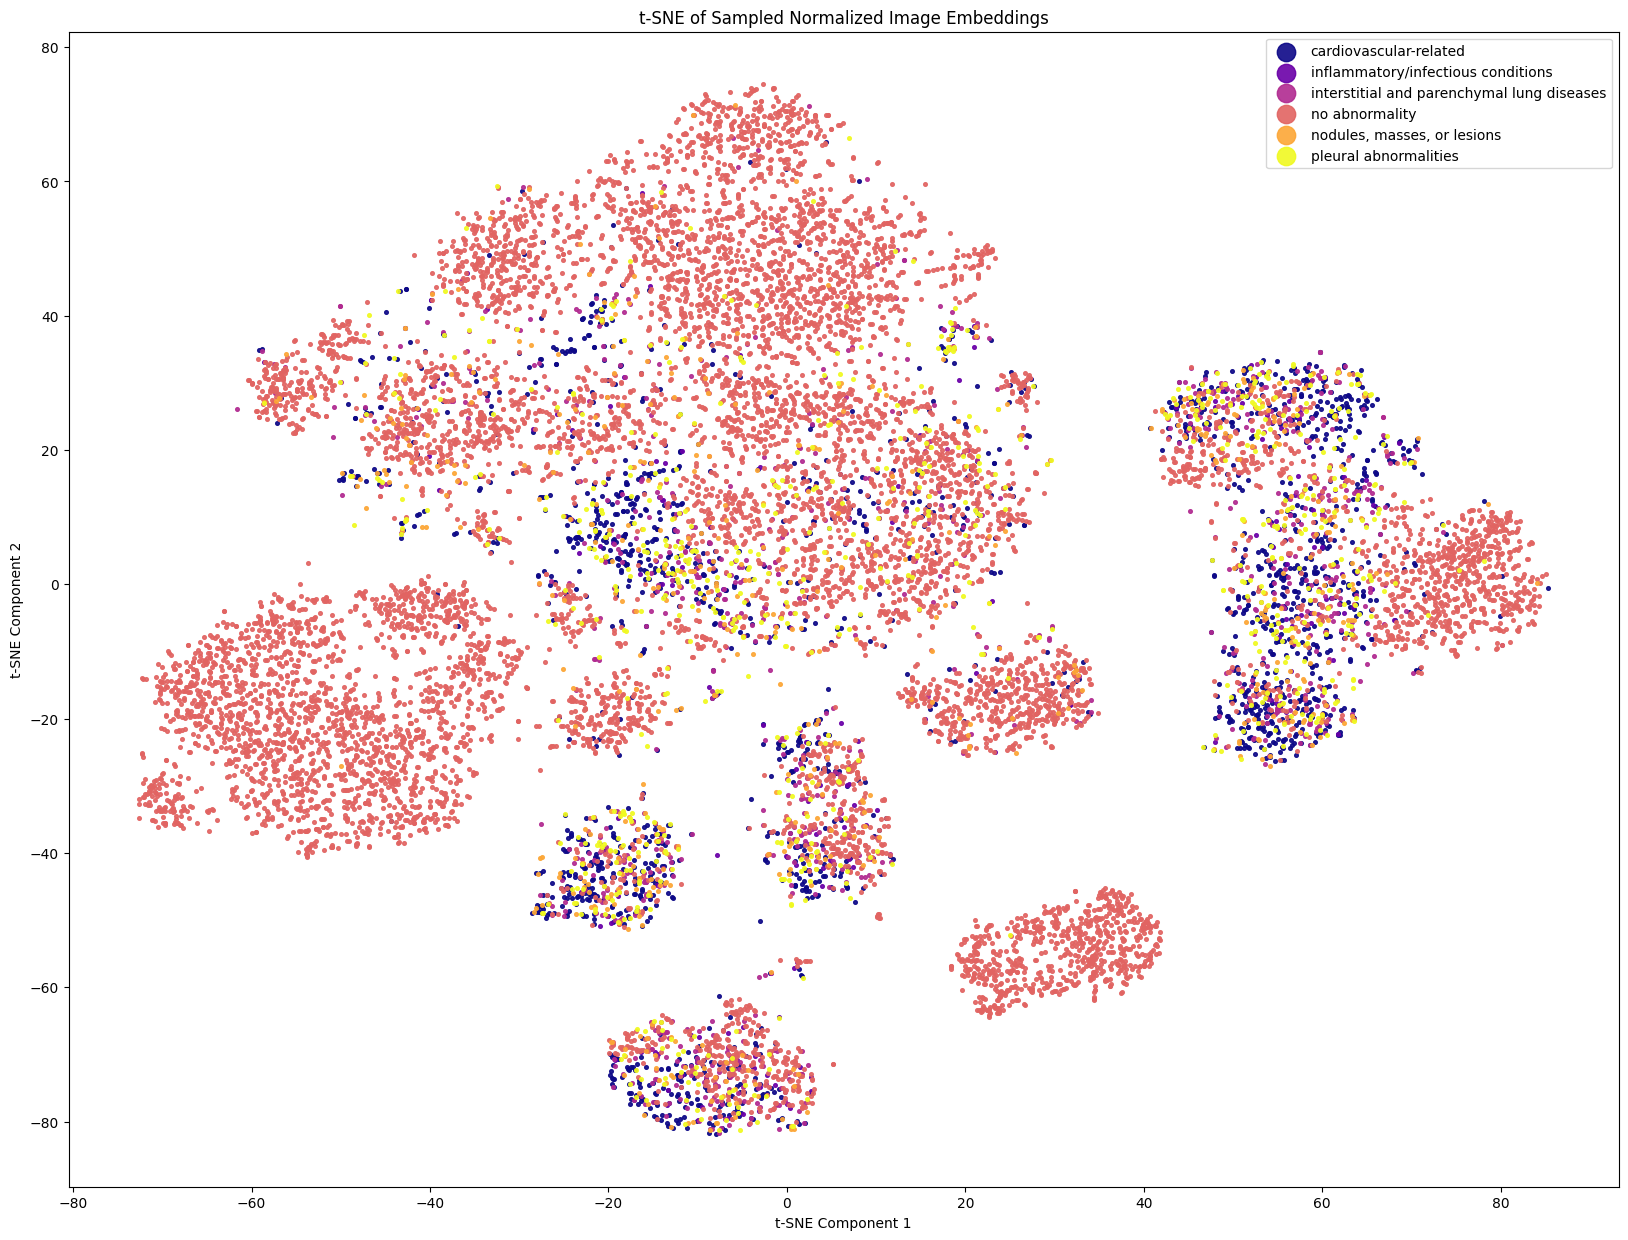

In [ ]:
#Plotting with color for each label
plt.figure(figsize=(20, 15))  # Increase the figure size

#Use unique labels for consistent coloring
uniqueLabels = np.unique(embeddedSamplesLabels)
colors = plt.cm.get_cmap("plasma", len(uniqueLabels))

#Map each label to a color
labelToColor = {label: colors(i) for i, label in enumerate(uniqueLabels)}

#Plot each point, colored by its label
for label in uniqueLabels:
    indices = embeddedSamplesLabels == label
    plt.scatter(
        embeddings2DNormalized[indices, 0],
        embeddings2DNormalized[indices, 1],
        s=7,
        alpha=.9,
        color=labelToColor[label],
        label=label
    )

plt.title('t-SNE of Sampled Normalized Image Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc="best", markerscale=5, fontsize='medium')
plt.show()


Baseline Model Accuracy

In [ ]:
print(allData.head())
print(allData.shape)
print(allData.columns)


                           image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          no finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          no finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          no finding        14    R10   

    x_min   y_min   x_max   y_max           grouped_class  
0     NaN     NaN     NaN     NaN          no abnormality  
1     NaN     NaN     NaN     NaN          no abnormality  
2   691.0  1375.0  1653.0  1831.0  cardiovascular-related  
3  1264.0   743.0  1611.0  1019.0  cardiovascular-related  
4     NaN     NaN     NaN     NaN          no abnormality  
(67914, 9)
Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min',
       'x_max', 'y_max', 'grouped_class'],
      dtype='object')


In [10]:
trainDir = "/content/drive/MyDrive/VinCR/jpg/train" #/Users/MaxS/Desktop/VinCR/jpg/train
testDir = "/content/drive/MyDrive/VinCR/jpg/test"

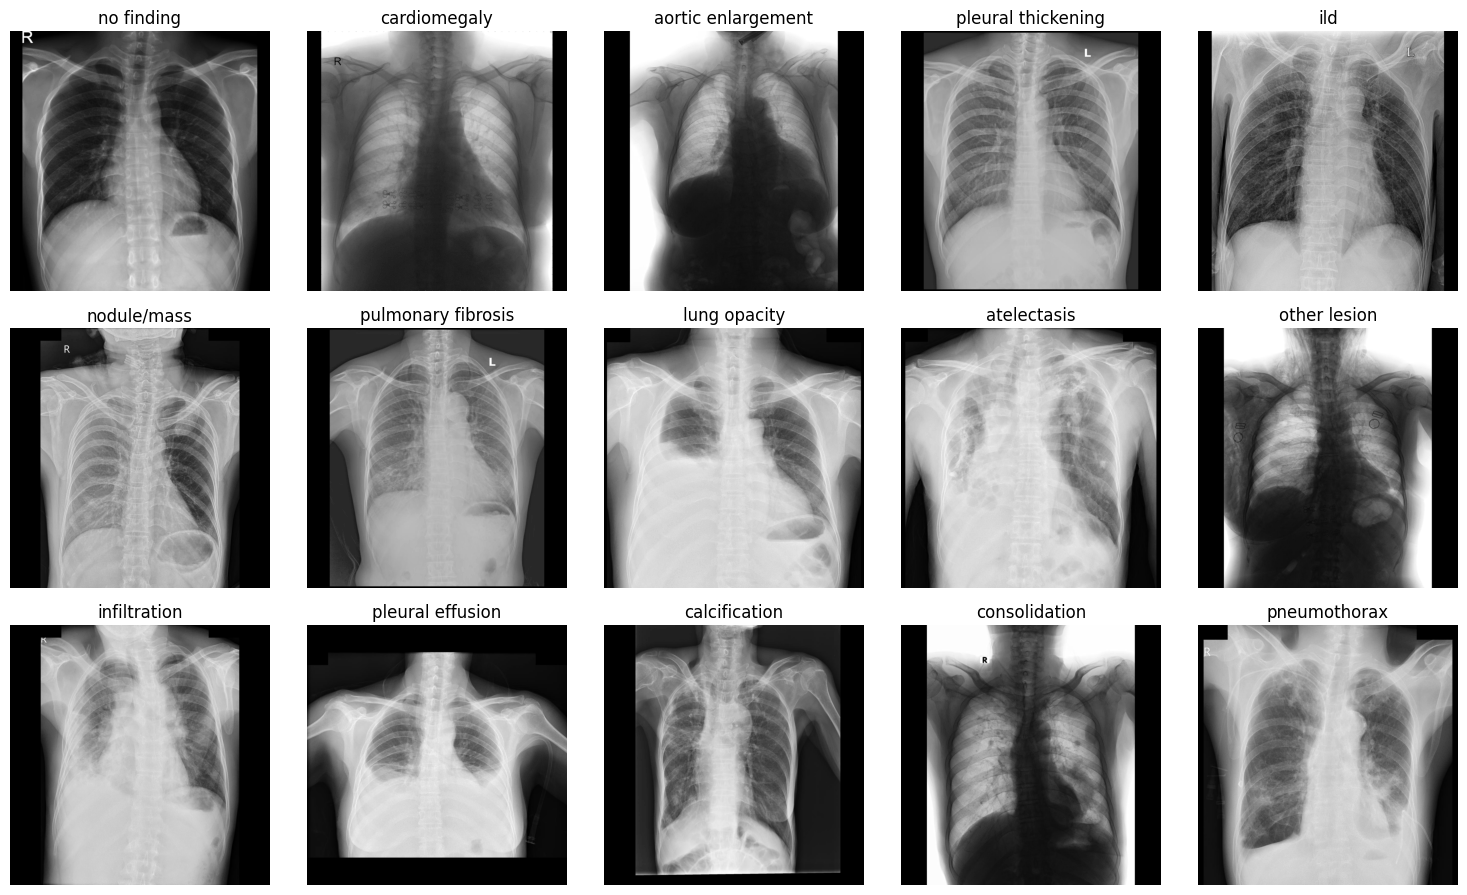

In [11]:
# Path to the image folder
image_path = '/content/drive/MyDrive/VinCR/jpg/train'

# Group the DataFrame to get one sample per unique class
unique_samples = allData.groupby('class_name').head(1)

# Set up the plot
plt.figure(figsize=(15, 15))

# Display each unique image
for i, row in enumerate(unique_samples.itertuples(), start=1):
    image_id = row.image_id
    image_file = os.path.join(image_path, f"{image_id}.jpg")

    if os.path.exists(image_file):  # Check if the image file exists
        img = Image.open(image_file).convert('L')  # Convert image to grayscale (black and white)

        # Display the image
        plt.subplot(5, 5, i)  # Adjust the grid size as needed
        plt.imshow(img, cmap="gray")
        plt.title(row.class_name)
        plt.axis('off')

    if i >= 25:  # Limit to displaying up to 25 images (adjust as needed)
        break

plt.tight_layout()
plt.show()


In [12]:
#Get the 15,000 image names
trainImages = [f.split('.')[0] for f in os.listdir(trainDir) if f.endswith('.jpg')]

In [13]:
reclassifiedData.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,grouped_class,grouped_id
0,50a418190bc3fb1ef1633bf9678929b3,no finding,14,R11,NaN,NaN,NaN,NaN,no finding,0
1,21a10246a5ec7af151081d0cd6d65dc9,no finding,14,R7,NaN,NaN,NaN,NaN,no finding,0
2,9a5094b2563a1ef3ff50dc5c7ff71345,cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,cardiovascular-related,1
3,051132a778e61a86eb147c7c6f564dfe,aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,cardiovascular-related,1
4,063319de25ce7edb9b1c6b8881290140,no finding,14,R10,NaN,NaN,NaN,NaN,no finding,0


In [14]:
#reclassifiedData grouped_class grouped_id
trainImagesSet = set(trainImages)

#Filter allData to get the train images, but there duplicates throughout it
trainData = allData[allData['image_id'].apply(lambda x: x in trainImagesSet)]

#Drop duplicate image_ids, keep only first bc they are repeats
trainDataFiltered = trainData.drop_duplicates(subset='image_id', keep='first')[['image_id', 'grouped_class', 'grouped_id']] #'class_name', 'class_id']]

print(f"Filtered training data size: {len(trainDataFiltered)}")


Filtered training data size: 15000


In [15]:
trainDataFiltered.head()

,image_id,grouped_class,grouped_id
0,50a418190bc3fb1ef1633bf9678929b3,no finding,0
1,21a10246a5ec7af151081d0cd6d65dc9,no finding,0
2,9a5094b2563a1ef3ff50dc5c7ff71345,cardiovascular-related,1
3,051132a778e61a86eb147c7c6f564dfe,cardiovascular-related,1
4,063319de25ce7edb9b1c6b8881290140,no finding,0


<ipython-input-16-d899eb320d53>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classCounts.index, y=classCounts.values, palette='RdBu')


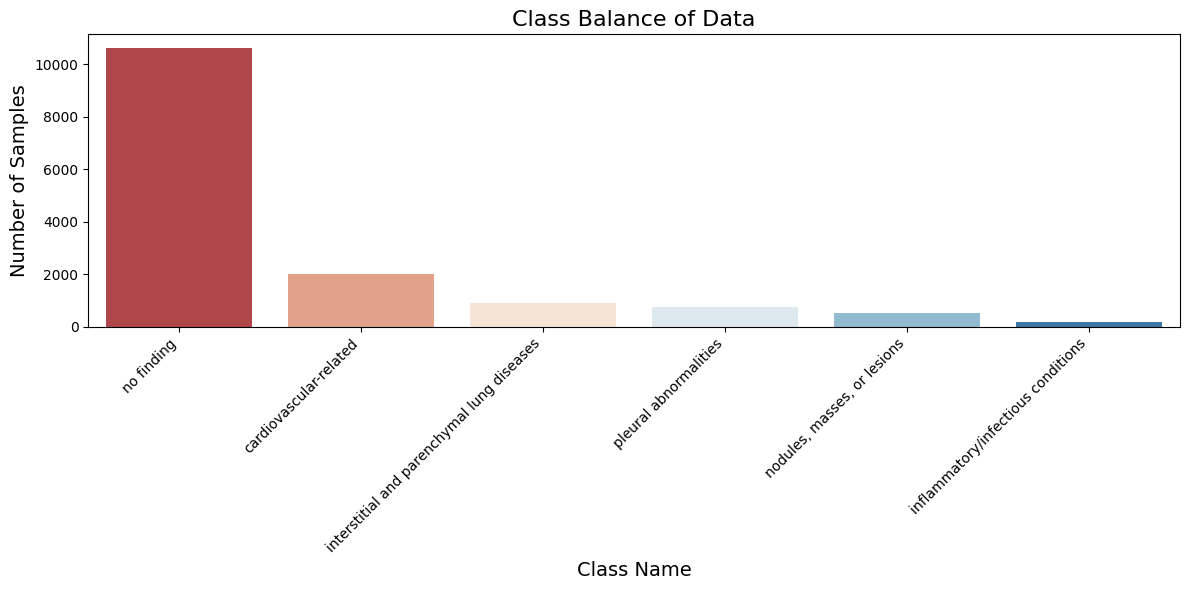

In [16]:
classCounts = trainDataFiltered['grouped_class'].value_counts()
#classCounts = trainDataFiltered['class_name'].value_counts()


plt.figure(figsize=(12, 6))
sns.barplot(x=classCounts.index, y=classCounts.values, palette='RdBu')

plt.title('Class Balance of Data', fontsize=16)
plt.xlabel('Class Name', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
class LungDiseaseDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.dataframe.iloc[idx, 0]}.jpg")
        image = Image.open(img_name).convert("RGB")
        label = self.dataframe.iloc[idx]['class_id']

        if self.transform:
            image = self.transform(image)

        #Convert label to a tensor
        label = torch.tensor(label, dtype=torch.long)
        return image, label




In [ ]:
# Split the data
train_data, val_test_data = train_test_split(trainDataFiltered, test_size=0.2, stratify=trainDataFiltered['grouped_id']) #stratify=trainDataFiltered['class_id']) "grouped_id"
val_data, test_data = train_test_split(val_test_data, test_size=0.5, stratify=val_test_data['grouped_id']) #stratify=val_test_data['class_id'])

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)


transform = transforms.Compose([
    transforms.Resize((224, 224)),   #Resize images to 224x224 (input size for DenseNet)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #Matches DenseNet's pretraining
])


#Create datasets
train_dataset = LungDiseaseDataset(dataframe=train_data, img_dir=trainDir, transform=transform)
val_dataset = LungDiseaseDataset(dataframe=val_data, img_dir=trainDir, transform=transform)
test_dataset = LungDiseaseDataset(dataframe=test_data, img_dir=trainDir, transform=transform)

print(len(train_dataset))

(12000, 3)
(1500, 3)
(1500, 3)
12000


In [ ]:
batch_size = 32 #16 worked for smaller subset dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#Tells us how many batches are in these
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

375
47
47


In [ ]:
#print first 3 batch infos in training loader
# for i, (data, target) in enumerate(train_loader):
#     if i >= 3:
#         break
#     print(f"Batch {i+1} - Data: {data.shape}, Target: {target}")


Batch 1 - Data: torch.Size([32, 3, 224, 224]), Target: tensor([ 0, 14, 14, 14, 14, 14,  8, 14, 14, 14, 14, 14, 14, 14,  6, 14, 14,  0,
        14, 14, 10,  2,  2, 14, 14, 14, 14, 14, 14,  7, 14, 14])
Batch 2 - Data: torch.Size([32, 3, 224, 224]), Target: tensor([14, 14, 14,  8, 13, 14, 14, 11,  3, 14,  7, 14,  3, 11,  0, 14, 14,  3,
         8, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14])
Batch 3 - Data: torch.Size([32, 3, 224, 224]), Target: tensor([14, 14,  3,  0, 14, 14,  3,  8, 14, 11, 14, 14,  3,  3,  0,  7, 14, 14,
        14,  7, 14, 14, 14, 14,  3, 14,  3,  0,  7,  0,  0, 14])


In [ ]:
#NOTE: this is the DenseNet model we train and evaluate

#num_classes = trainDataFiltered['class_id'].nunique()  # 15 classes: 0 to 14
num_classes = trainDataFiltered['grouped_id'].nunique()  # 6 classes: 0 to 5


#model = models.densenet121(weights=True)
model = models.densenet121(weights='DEFAULT')

#Update the final layer for our 15 classes
model.classifier = nn.Linear(model.classifier.in_features, num_classes)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 85.2MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(device)

cpu


In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            #print("image finished")
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader)}")
        validate_model(model, val_loader)

# Validation function
def validate_model(model, val_loader):
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())
    accuracy = accuracy_score(val_labels, val_preds)
    print(f"Validation Accuracy: {accuracy:.4f}")


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def test_model(model, test_loader):
    model.eval()
    test_labels = []
    test_preds = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", unit="batch"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())
    accuracy = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {accuracy:.4f}")



Test Accuracy: 0.7167


In [ ]:
test_model(model, test_loader)


Below is Tensorflow version of training/testing DenseNet
- Not familiar with Tensorflow so I used chatgpt to convert the relevant code

In [ ]:
# train_data, val_test_data = train_test_split(trainDataFiltered, test_size=0.2, stratify=trainDataFiltered['class_id'], random_state=42)
# val_data, test_data = train_test_split(val_test_data, test_size=0.5, stratify=val_test_data['class_id'], random_state=42)

# num_classes = trainDataFiltered['class_id'].nunique()  # 15 classes: 0 to 14

# # Data generator class
# class LungDiseaseDataset(tf.keras.utils.Sequence):
#     def __init__(self, dataframe, img_dir, batch_size=16, img_size=(224, 224), shuffle=True):
#         self.dataframe = dataframe
#         self.img_dir = img_dir
#         self.batch_size = batch_size
#         self.img_size = img_size
#         self.shuffle = shuffle
#         self.indexes = np.arange(len(self.dataframe))
#         self.on_epoch_end()

#     def __len__(self):
#         return int(np.floor(len(self.dataframe) / self.batch_size))

#     def __getitem__(self, index):
#         indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         batch_data = self.dataframe.iloc[indexes]

#         images = []
#         labels = []

#         for _, row in batch_data.iterrows():
#             img_path = os.path.join(self.img_dir, f"{row['image_id']}.jpg")
#             image = Image.open(img_path).convert("RGB")
#             image = image.resize(self.img_size)
#             image = np.array(image) / 255.0  # Normalize to [0, 1] range
#             images.append(image)
#             labels.append(row['class_id'])

#         images = np.stack(images, axis=0)
#         labels = np.array(labels)
#         labels = to_categorical(labels, num_classes=len(self.dataframe['class_id'].unique()))

#         return images, labels

#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indexes)

# # Create data generators
# train_dataset = LungDiseaseDataset(dataframe=train_data, img_dir=trainDir)
# val_dataset = LungDiseaseDataset(dataframe=val_data, img_dir=trainDir)
# test_dataset = LungDiseaseDataset(dataframe=test_data, img_dir=testDir)

# # Example to test the data generator
# sample_images, sample_labels = train_dataset.__getitem__(0)
# print(f"Batch shape (images): {sample_images.shape}")
# print(f"Batch shape (labels): {sample_labels.shape}")


Batch shape (images): (16, 224, 224, 3)
Batch shape (labels): (16, 15)


In [ ]:

# # Model initialization using pre-trained DenseNet121
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# #maybe set this to be False
# base_model.trainable = False  # Fine-tune the entire model

# # Add a new classifier layer
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(num_classes, activation='softmax')
# ])

# # Compile the model
# model.compile(
#     optimizer=optimizers.Adam(learning_rate=0.001),
#     loss=losses.CategoricalCrossentropy(),
#     metrics=['accuracy']
# )

# # Training function
# def train_model(model, train_dataset, val_dataset, num_epochs=10):
#     history = model.fit(
#         train_dataset,
#         validation_data=val_dataset,
#         epochs=num_epochs,
#         verbose=1  # Progress bar for batches
#     )
#     return history

# # Validation function (Keras handles this internally, but to keep a separate version)
# def validate_model(model, val_dataset):
#     val_preds = []
#     val_labels = []
#     for images, labels in val_dataset:
#         preds = model.predict(images)
#         preds = np.argmax(preds, axis=1)
#         val_preds.extend(preds)
#         val_labels.extend(labels.numpy())

#     accuracy = accuracy_score(val_labels, val_preds)
#     print(f"Validation Accuracy: {accuracy:.4f}")



In [ ]:
# # Assuming `train_dataset` and `val_dataset` are `tf.data.Dataset` objects or Keras generators
# train_history = train_model(model, train_dataset, val_dataset, num_epochs=10)
# validate_model(model, val_dataset)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 52/750 ━━━━━━━━━━━━━━━━━━━━ 2:19:25 12s/step - accuracy: 0.4753 - loss: 2.0329

KeyboardInterrupt: 